# Regression

In the exercises today we will switch focus to regression, another cornerstone in machine learning.

The big aim in regression is to predict a continuous quantity that is a function of the inputs, instead of assigning a discrete label as in classification.

You are probably already very familiar with regression through linear regression, where you can calculate the line of best fit to your data. Here we are doing nothing different except we allow a network to learn that functional form instead of using an Ansatz and minimise our $\chi^2$ through least squares.

You can also use tensorflow do do this for you though!

Imagine a network that takes one input, has a couple of hidden layers and an output node for each parameter in your equation, which you then combine to create the output.
So for a linear fit we would have two output nodes, one for $m$ and the other for $c$, and we define our output as $y=mx+c$.

Then as a loss function we can take the square difference between the prediction and the input value,

$Loss=\Sigma_{i=1}^N |y^i_{pred} - y^i_{true}|^2 / N$

and train our network in exactly the same way as our classifier!

However, we are typically training a network to learn something far more complicated than that, but that very loss is a common choice in regression tasks - known as the *mean squared error* or *L2_norm*.

There are several choices for regression losses, all following different functional forms such as:
* Mean absolute error - linear in deviation
* Mean square error - quadratic in deviation
* logcosh - near quadratic at small deviations, near linear at large deviations
* Huber loss - like logcosh, but with more freedome to optimise trade off

Which is different to classification where we stick to cross-entropy, and there is no set "best" loss to use, it really is task specific!

However, training a regression network is otherwise identical to a classification network, though our measure of performance is also now different - no more ROC curves, instead it will be completely down to the task!

Just like with cross entropy these losses are within easy reach in keras and pytorch, and you can import them or use strings when compiling the model.

In [1]:
from tensorflow.keras.losses import mse,mae,huber,logcosh

# Dataset

Today we will also be moving away from the flavour tagging dataset, which had a vector for inputs, and on to something quite different - energy deposits in the ATLAS detector caused by a single particle.

These energy deposits are in a coarse grid is cells, but coarser in granularity than the particles themselves. However, being grid-like we can visualise them as images!

For these exercises we always take a 7x7 grid of cells centred on the incoming particle, however the detector is made up of many more cells arrayed in a large number of layers with varying granularity (both as you scan around the detector but also away from the centre).

However, even though we centre the selection of cells onto the one the particle hit, that doesn't mean the particle hit the very centre of the cell! It can be that it was offset. The task this week will be to predict that offset.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import h5py
import numpy as np

In [3]:
dataset = h5py.File("data/cell_regression_65gev.h5")

Here are some example showers, the first 25 from the file.

The offset is given in terms of $\Delta\eta$ and $\Delta\phi$. These are just like $x$ and $y$ coordinates but using the detector coordinate system. The cells are labelled by number and the offset values of the incident particle are relative to the centre of the centre cell.

The cell energies are shown by the colour of the pixel.

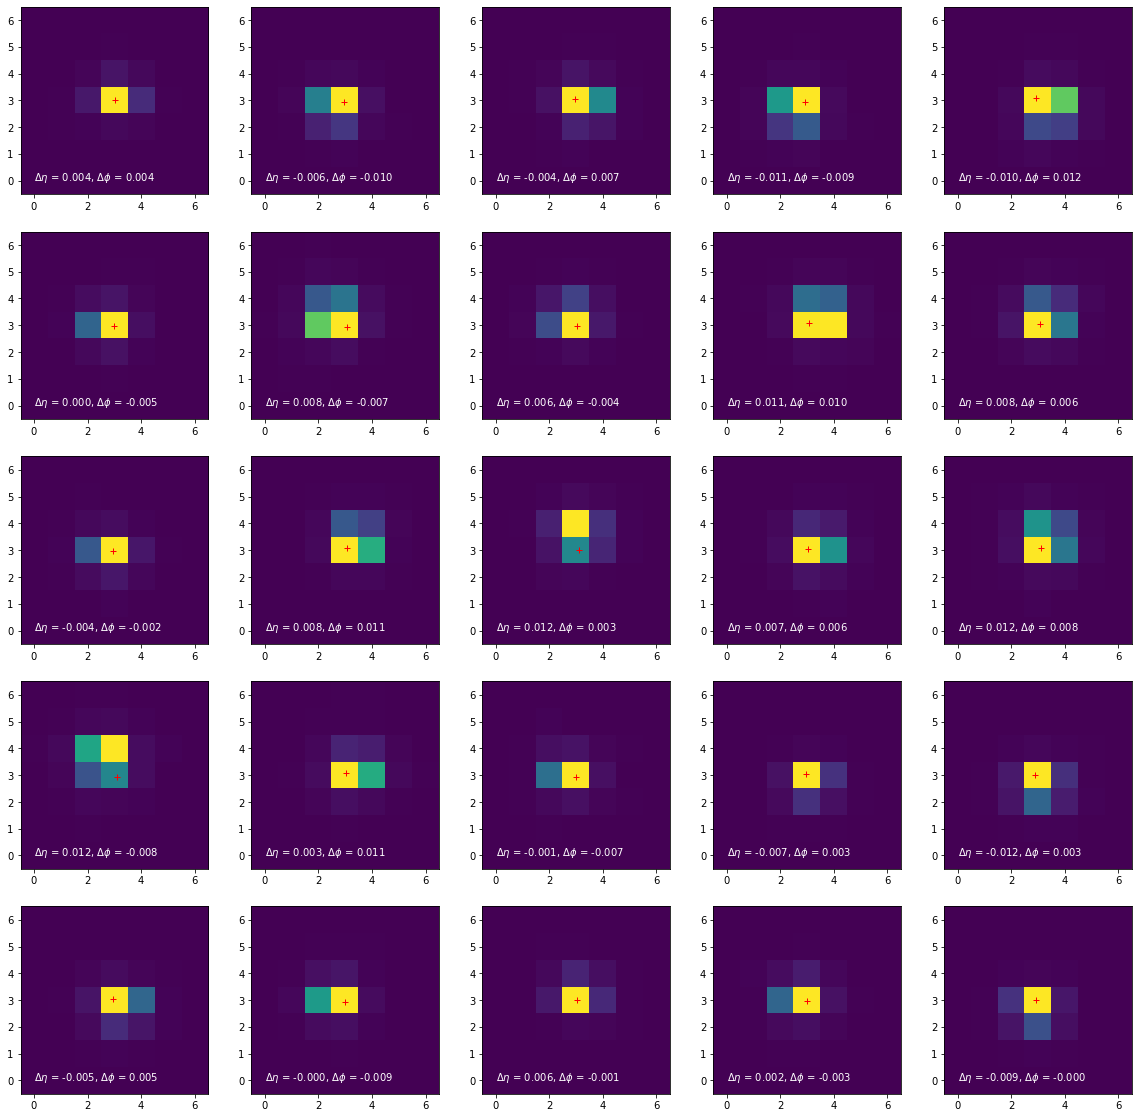

In [4]:
from utils import plot_showers
plot_showers(dataset)

As we can see, the depositions are centred around the centre cell, but there are various spreads outside which are more often than not in agreement with the displacement.

We can get the cell energies and the two truth targets from the file.

In [5]:
cell_energies = dataset['cell_energies'][:]
truth_eta = dataset['truth_eta'][:]
truth_phi = dataset['truth_phi'][:]

As we only have one channel in our image, we actually have it saved as a rank three tensor, but for training a model we will want to change this to rank 4 as this is how tensorflow deals with images.

In [6]:
print(f"Original shape: {cell_energies.shape}")
print(f"np.newaxis: {cell_energies[...,np.newaxis].shape}")#we can use the np.newaxis object with indexing
print(f"expand_dims: {np.expand_dims(cell_energies,-1).shape}")#or we can use the numpy expand dims function
print(f"reshape: {cell_energies.reshape(cell_energies.shape+(1,)).shape}")#or from the numpy array with can reshape directly
cell_energies = cell_energies[...,np.newaxis]

Original shape: (10000, 7, 7)
np.newaxis: (10000, 7, 7, 1)
expand_dims: (10000, 7, 7, 1)
reshape: (10000, 7, 7, 1)


We can see the trend we are trying to learn from the cell energiesby looking at the energy-displacement weighted sum in each axis versus the displacement.

Here we plot a 2D histogram of the target as a function of this variables in both $\eta$ and $\phi$

$$
  E_\phi = \frac{\Sigma_{i}^{Ncells} (\phi^{cell}_i - \phi^{centre})\cdot E^{cell}_i}{\Sigma_{j}^{Ncells} E^{cell}_j}
$$

$$
  E_\eta = \frac{\Sigma_{i}^{Ncells} (\eta^{cell}_i -\eta^{centre})\cdot E^{cell}_i}{\Sigma_{j}^{Ncells} E^{cell}_j}
$$

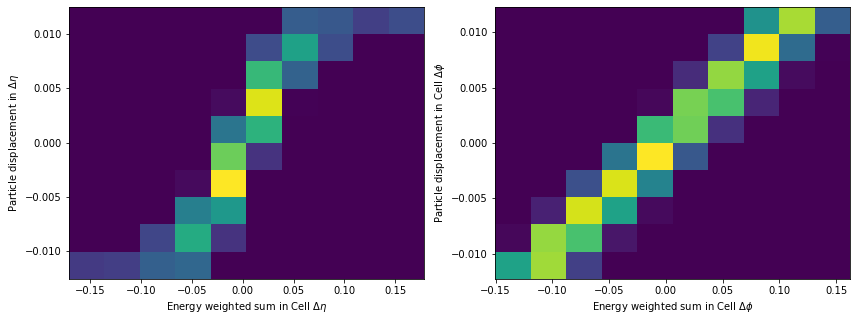

In [7]:
from utils import plot_eta_phi_relationship
plot_eta_phi_relationship(cell_energies,truth_eta,truth_phi)

# Image input - Convolutional Layers!

Also, as we are dealing with images as an input, you will need to become familiar with another type of layer!

Up until now all we have used are dense (linear) layers, which comprise a set of nodes all connected to all inputs/nodes in the previous layer.

With a vector as an input this makes sense, however for images we are often looking for structure in the image and want to treat all pixels the same.

For this exact example this is not always going to be necessarily true as the images have already been centred and cropped, and the number of pixels is small, but for bigger images of objects this is going to be critical!

In a convolutional layer you instead work with a kernel - a small window of `(NxM)` in size (smaller than the image). This window slides over the whole image with steps of a chosen size (typically 1x1 step, meaning you just slide it one pixel along the x axis and/or one pixel on along the y axis).

At each step the window is covering `N*M` pixels. each pixel is multiplied by a learned weight and with the addition of a bias a sum is taken over all of them (just like in a linear layer). This is then the output value of the pixel for that step in the next layer. Just like in linear layers, we apply non-linear activations onto the output values.

As the window slides over the input image, it builds the output image.

In the case of a multi-colour image, this window can take all colours as an input, with each colour having its own weight.

Further more, the output image can also have multiple channels (colours) as an output, with each output channel having its own weights.

Finally, as a kernel with size greater than 1x1 or with a stride greater than 1x1, if you wish to preserve the overall size of an image, we need to "pad" the image. This is done by adding a border of zeros to the image.
Otherwise if we wish to increase the size of the image, we can add find ways to upsample the image - often by inserting values with a given pattern or duplicating pixels. However, for this task this will not be necessary.

## Going from image to vector

In most tasks we don't want an image as our output! So we need to find some way to go from an ND input to a 1D.

If we look at tensors, we have up until now been handling rank 2 tensors with a shape `(Nbatch,Nfeatures)`, but with an image we have a rank-4 tensor `(Nbatch, Nx, Ny, Nchannels)`. (Depending on your data/ml framework you may get it in the form `(Nbatch, Nchannels, Nx, Ny)`)

There are a couple of ways to get back to a rank-2 tensor. The first is to "unravel" the whole image into a tensor of shape `(Nbatch, Nchannels*Nx*Ny)`. We can then use this with normal dense layers.

Another way is to apply a pooling operation. This can be done across any of the axes individually, or across several simultaneously. In a pooling operation we perform an order-invariant operation like a sum, a product, or taking the max.
* It might be interesting to look at the average value for each of the channels, or perhaps take the max value per channel!

## In tensorflow

All of these layers and operations are predefined for you in both tensorflow.keras (and pytorch) so you don't need to write them yourselves.

Instead you can import the most useful ones with

In [11]:
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, GlobalMaxPooling2D

In [12]:
#Don't forget you can always get the help statements without going to the API website!
print(help(GlobalAveragePooling2D))

Help on class GlobalAveragePooling2D in module keras.layers.pooling:

class GlobalAveragePooling2D(GlobalPooling2D)
 |  GlobalAveragePooling2D(*args, **kwargs)
 |  
 |  Global average pooling operation for spatial data.
 |  
 |  Examples:
 |  
 |  >>> input_shape = (2, 4, 5, 3)
 |  >>> x = tf.random.normal(input_shape)
 |  >>> y = tf.keras.layers.GlobalAveragePooling2D()(x)
 |  >>> print(y.shape)
 |  (2, 3)
 |  
 |  Args:
 |      data_format: A string,
 |        one of `channels_last` (default) or `channels_first`.
 |        The ordering of the dimensions in the inputs.
 |        `channels_last` corresponds to inputs with shape
 |        `(batch, height, width, channels)` while `channels_first`
 |        corresponds to inputs with shape
 |        `(batch, channels, height, width)`.
 |        It defaults to the `image_data_format` value found in your
 |        Keras config file at `~/.keras/keras.json`.
 |        If you never set it, then it will be "channels_last".
 |      keepdims: A 

Now you can build a model just like in previous examples, however watch out that you get the input shape right!

In [13]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

In [14]:
ins = Input(shape=(7,7,1))
h1 = Conv2D(filters=3,
            kernel_size=(3,3),
            strides=(1,1),
            padding='valid',
            data_format='channels_last',
            activation='relu')(ins)
h2 = Conv2D(filters=8,
            kernel_size=(3,3),
            strides=(1,1),
            padding='valid',
            data_format='channels_last',
            activation='relu')(h1)
h3 = GlobalAveragePooling2D()(h2)
h4 = Dense(units=4,activation='relu')(h3)
outs = Dense(units=1,activation='linear')(h4)
model = Model(inputs=ins,outputs=outs)

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7, 7, 1)]         0         
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 3)           30        
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 3, 8)           224       
                                                                 
 global_average_pooling2d (G  (None, 8)                0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 4)                 36        
                                                                 
 dense_1 (Dense)             (None, 1)                 5         
                                                             

Here we have built a very simple model that:
* Takes our image as an input
* Passes it through two convolutional layers without padding (this makes the output image smaller each time)
* Takes the average of each channel in 2D
* Passes the average pooled output through a dense layer
* Precits one output

# Physics inspired modelling

We can, however, build far more sensible and sophisticated models if we are dealing with multiple outputs by being inspired from the physics.

If we know the target is only dependent on information in one dimension (though a different dimension for each dimension of our target) we can use that prior knowledge to design our model.

In [16]:
from tensorflow.keras.layers import Lambda
import tensorflow.keras.backend as K
ins = Input(shape=(7,7,1))

sumeta = Lambda(lambda x: K.sum(x,axis=(1,3)))(ins)
eta_h1 = Dense(units=4,activation='relu')(sumeta)
eta_h2 = Dense(units=4,activation='relu')(eta_h1)
deta = Dense(units=1,activation='linear')(eta_h2)

sumphi = Lambda(lambda x: K.sum(x,axis=(2,3)))(ins)
phi_h1 = Dense(units=4,activation='relu')(sumphi)
phi_h2 = Dense(units=4,activation='relu')(phi_h1)
dphi = Dense(units=1,activation='linear')(phi_h2)

split_model = Model(inputs=ins,outputs=[deta,dphi])

In [17]:
split_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 7, 7, 1)]    0           []                               
                                                                                                  
 lambda (Lambda)                (None, 7)            0           ['input_2[0][0]']                
                                                                                                  
 lambda_1 (Lambda)              (None, 7)            0           ['input_2[0][0]']                
                                                                                                  
 dense_2 (Dense)                (None, 4)            32          ['lambda[0][0]']                 
                                                                                            

For ML in physics it is often very useful to put your intuition and physics knowledge into the model design!

Here we have taken the sum over all cells in either eta or phi, turning it into a 1D set of energies each, and then split the problem into two.

When defining ML models not everything needs to be sequential and we are free to split things up!

Here we have forked our problem into two, and have two output layers which we just need to pass to the model as a tuple.

# Exercises

Get familiar with building and training models with convolutional layers.

Remember, this data is not yet preprocessed so you will want to apply what you learned last week to the inputs and targets. For images it is best to treat all pixels the same.

1. Train a network predicting either truth_eta or truth_phi
  * Try a couple of the losses
  * Look at the impact of preprocessing and model design!
  
2. Train a network predicting both truth_eta and truth_phi
  * Does it perform better at one compared to the other?
  * Can you modify the loss to favour one dimension over the other? [link](https://keras.io/api/losses/#creating-custom-losses)

# Extension

In the data folder is another file with particles of various energies.

1. Try evaluating your trained model with this data for the different energy values. The energy values increase each time by a factor of 2 from the previous energy.

2. You can now try to train the model using all energy points, does it work better?

3. You should now pass the energy information to the network, you can do this by specifying multiple inputs (just like we can have multiple outputs).
  * One idea is to concatenate the energy value to the output of your pooled layer like this:

In [18]:
from tensorflow.keras.layers import Concatenate

in_cells = Input(shape=(7,7,1))
in_e = Input(shape=(1,))
h1 = Conv2D(filters=3,
            kernel_size=(3,3),
            strides=(1,1),
            padding='valid',
            data_format='channels_last',
            activation='relu')(in_cells)
h2 = Conv2D(filters=8,
            kernel_size=(3,3),
            strides=(1,1),
            padding='valid',
            data_format='channels_last',
            activation='relu')(h1)
h3 = GlobalAveragePooling2D()(h2)
h4 = Concatenate(axis=-1)([h3,in_e])
h5 = Dense(units=4,activation='relu')(h4)
outs = Dense(units=1,activation='linear')(h5)
model = Model(inputs=[in_cells,in_e],outputs=outs)

In [19]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 7, 7, 1)]    0           []                               
                                                                                                  
 conv2d_2 (Conv2D)              (None, 5, 5, 3)      30          ['input_3[0][0]']                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 3, 3, 8)      224         ['conv2d_2[0][0]']               
                                                                                                  
 global_average_pooling2d_1 (Gl  (None, 8)           0           ['conv2d_3[0][0]']               
 obalAveragePooling2D)                                                                      

To assess the performance, plot two curves: the true value and your prediction.

Do this for all energy values separately and inclusively.